# Fine-tuning a Torch object detection model

<a id="try-anyscale-quickstart-torch_detection" href="https://www.anyscale.com/ray-on-anyscale?utm_source=ray_docs&utm_medium=docs&utm_campaign=torch_detection">
    <img src="../../../_static/img/run-on-anyscale.svg" alt="try-anyscale-quickstart">
</a>
<br></br>

This tutorial explains how to fine-tune `fasterrcnn_resnet50_fpn` using the Ray AI libraries for parallel data ingest and training.

Here's what you'll do:
1. Load raw images and [VOC-style](http://host.robots.ox.ac.uk/pascal/VOC/) annotations into a Dataset
2. Fine-tune `fasterrcnn_resnet50_fpn` (the backbone is pre-trained on ImageNet)
3. Evaluate the model's accuracy

You should be familiar with [PyTorch](https://pytorch.org/) before starting the
tutorial. If you need a refresher, read PyTorch's
[training a classifier](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)
tutorial.

## Before you begin

* Install the dependencies for Ray Data and Ray Train.

In [ ]:
!pip install 'ray[data,train]'

* Install `torch`, `torchmetrics`, `torchvision`, and `xmltodict`.

In [ ]:
!pip install torch torchmetrics torchvision xmltodict

## Create a `Dataset`

You'll work with a subset of [Pascal VOC](http://host.robots.ox.ac.uk/pascal/VOC/) that contains cats and dogs (the full dataset has 20 classes).

In [1]:
CLASS_TO_LABEL = {
    "background": 0,
    "cat": 1,
    "dog": 2,
}

The dataset contain two subdirectories: `JPEGImages` and `Annotations`. `JPEGImages` contains raw images, and
`Annotations` contains XML annotations.

```
AnimalDetection
├── Annotations
│   ├── 2007_000063.xml
│   ├── 2007_000528.xml
│   └──  ...
└── JPEGImages
    ├── 2007_000063.jpg
    ├── 2007_000528.jpg
    └──  ...
```

### Parse annotations

Each annotation describes the objects in an image.

For example, view this image of a dog:

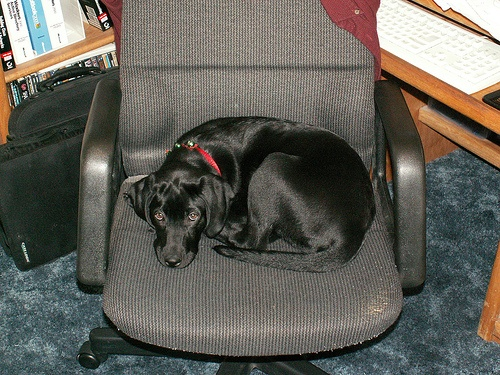

In [2]:
import io

from PIL import Image
import requests

response = requests.get("https://s3-us-west-2.amazonaws.com/air-example-data/AnimalDetection/JPEGImages/2007_000063.jpg")
image = Image.open(io.BytesIO(response.content))
image

Then, print the image's annotation:

In [3]:
!curl "https://s3-us-west-2.amazonaws.com/air-example-data/AnimalDetection/Annotations/2007_000063.xml"

<?xml version="1.0" encoding="utf-8"?>
<annotation>
	<folder>VOC2012</folder>
	<filename>2007_000063.jpg</filename>
	<source>
		<database>The VOC2007 Database</database>
		<annotation>PASCAL VOC2007</annotation>
		<image>flickr</image>
	</source>
	<size>
		<width>500</width>
		<height>375</height>
		<depth>3</depth>
	</size>
	<segmented>1</segmented>
	<object>
		<name>dog</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>123</xmin>
			<ymin>115</ymin>
			<xmax>379</xmax>
			<ymax>275</ymax>
		</bndbox>
	</object>
</annotation>

Notice how there's one object labeled "dog"

```
<name>dog</name>
<pose>Unspecified</pose>
<truncated>0</truncated>
<difficult>0</difficult>
<bndbox>
        <xmin>123</xmin>
        <ymin>115</ymin>
        <xmax>379</xmax>
        <ymax>275</ymax>
</bndbox>
```

[Ray Data](data) lets you read and preprocess data in parallel. Ray Data doesn't
have built-in support for VOC-style annotations, so you'll need to define logic to parse the annotations.

In [4]:
from typing import Any, Dict, List, Tuple

import xmltodict


def decode_annotation(row: Dict[str, Any]) -> Dict[str, Any]:
    text = row["bytes"].decode("utf-8")
    annotation = xmltodict.parse(text)["annotation"]

    objects = annotation["object"]
    # If there's one object, `objects` is a `dict`; otherwise, it's a `list[dict]`.
    if isinstance(objects, dict):
        objects = [objects]

    boxes: List[Tuple] = []
    for obj in objects:
        x1 = float(obj["bndbox"]["xmin"])
        y1 = float(obj["bndbox"]["ymin"])
        x2 = float(obj["bndbox"]["xmax"])
        y2 = float(obj["bndbox"]["ymax"])
        boxes.append((x1, y1, x2, y2))

    labels: List[int] = [CLASS_TO_LABEL[obj["name"]] for obj in objects]

    filename = annotation["filename"]

    return {
        "boxes": boxes,
        "labels": labels,
        "filename": filename,
    }


In [5]:
import os
import ray


path = "s3://anonymous@air-example-data/AnimalDetection/Annotations"
annotations: ray.data.Dataset = (
    ray.data.read_binary_files(path)
    .map(decode_annotation)
)

2025-03-10 21:44:27,975	INFO worker.py:1654 -- Connecting to existing Ray cluster at address: 10.0.49.230:6379...
2025-03-10 21:44:27,985	INFO worker.py:1832 -- Connected to Ray cluster. View the dashboard at https://session-l9djtlqx7qqeui6ppmc55icd5n.i.anyscaleuserdata.com 
2025-03-10 21:44:27,989	INFO packaging.py:367 -- Pushing file package 'gcs://_ray_pkg_5faf6ec023d53f8af2bda5976e1d23b9edab9b2d.zip' (0.61MiB) to Ray cluster...
2025-03-10 21:44:27,992	INFO packaging.py:380 -- Successfully pushed file package 'gcs://_ray_pkg_5faf6ec023d53f8af2bda5976e1d23b9edab9b2d.zip'.


Look at the first two samples. Ray Data should've correctly parsed labels and bounding boxes.

In [6]:
annotations.take(2)

2025-03-10 21:44:29,880	INFO dataset.py:2799 -- Tip: Use `take_batch()` instead of `take() / show()` to return records in pandas or numpy batch format.
2025-03-10 21:44:29,890	INFO streaming_executor.py:108 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2025-03-10_20-48-49_801322_2254/logs/ray-data
2025-03-10 21:44:29,890	INFO streaming_executor.py:109 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ListFiles] -> TaskPoolMapOperator[PartitionFiles] -> TaskPoolMapOperator[ReadFiles] -> TaskPoolMapOperator[Map(decode_annotation)] -> LimitOperator[limit=2]


Running 0: 0.00 row [00:00, ? row/s]

- ListFiles 1: 0.00 row [00:00, ? row/s]

- PartitionFiles 2: 0.00 row [00:00, ? row/s]

- ReadFiles 3: 0.00 row [00:00, ? row/s]

- Map(decode_annotation) 4: 0.00 row [00:00, ? row/s]

- limit=2 5: 0.00 row [00:00, ? row/s]

(autoscaler +24s) Tip: use `ray status` to view detailed cluster status. To disable these messages, set RAY_SCHEDULER_EVENTS=0.


[{'boxes': [[31.0, 166.0, 275.0, 415.0]],
  'labels': [1],
  'filename': '2010_002026.jpg'},
 {'boxes': [[109.0, 29.0, 428.0, 394.0]],
  'labels': [2],
  'filename': '2010_002029.jpg'}]

### Load images

Each row of `annotations` contains the filename of an image.

Write a user-defined function that loads these images. For each annotation, your function will:
1. Open the image associated with the annotation.
2. Add the image to a new `"image"` column.

In [7]:
from typing import Dict

import numpy as np
from PIL import Image


def read_images(row: Dict[str, np.ndarray]) -> Dict[str, np.ndarray]:
    url = os.path.join("https://s3-us-west-2.amazonaws.com/air-example-data/AnimalDetection/JPEGImages", row["filename"])
    response = requests.get(url)
    image = Image.open(io.BytesIO(response.content))
    row["image"] = np.array(image)
    return row


dataset = annotations.map(read_images)
dataset

2025-03-10 21:45:01,288	INFO streaming_executor.py:108 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2025-03-10_20-48-49_801322_2254/logs/ray-data
2025-03-10 21:45:01,289	INFO streaming_executor.py:109 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ListFiles] -> TaskPoolMapOperator[PartitionFiles] -> TaskPoolMapOperator[ReadFiles]


Running 0: 0.00 row [00:00, ? row/s]

- ListFiles 1: 0.00 row [00:00, ? row/s]

- PartitionFiles 2: 0.00 row [00:00, ? row/s]

- ReadFiles 3: 0.00 row [00:00, ? row/s]

Map(read_images)
+- Map(decode_annotation)
   +- Dataset(num_rows=?, schema={bytes: binary})

### Split the dataset into train and test sets

Once you've created a `Dataset`, split the dataset into train and test sets.

In [8]:
train_dataset, test_dataset = dataset.train_test_split(0.2)

2025-03-10 21:46:46,178	INFO streaming_executor.py:108 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2025-03-10_20-48-49_801322_2254/logs/ray-data
2025-03-10 21:46:46,178	INFO streaming_executor.py:109 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ListFiles] -> TaskPoolMapOperator[PartitionFiles] -> TaskPoolMapOperator[ReadFiles] -> TaskPoolMapOperator[Map(decode_annotation)->Map(read_images)] -> AggregateNumRows[AggregateNumRows]


Running 0: 0.00 row [00:00, ? row/s]

- ListFiles 1: 0.00 row [00:00, ? row/s]

- PartitionFiles 2: 0.00 row [00:00, ? row/s]

- ReadFiles 3: 0.00 row [00:00, ? row/s]

- Map(decode_annotation)->Map(read_images) 4: 0.00 row [00:00, ? row/s]

- AggregateNumRows 5: 0.00 row [00:00, ? row/s]

2025-03-10 21:49:52,272	INFO streaming_executor.py:108 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2025-03-10_20-48-49_801322_2254/logs/ray-data
2025-03-10 21:49:52,272	INFO streaming_executor.py:109 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ListFiles] -> TaskPoolMapOperator[PartitionFiles] -> TaskPoolMapOperator[ReadFiles] -> TaskPoolMapOperator[Map(decode_annotation)->Map(read_images)]


Running 0: 0.00 row [00:00, ? row/s]

- ListFiles 1: 0.00 row [00:00, ? row/s]

- PartitionFiles 2: 0.00 row [00:00, ? row/s]

- ReadFiles 3: 0.00 row [00:00, ? row/s]

- Map(decode_annotation)->Map(read_images) 4: 0.00 row [00:00, ? row/s]

## Define preprocessing logic

Create a function that preprocesses the images in the dataset. First, transpose and scale the images (`ToTensor`). Then,
randomly augment images every epoch (`RandomHorizontalFlip`). Apply this transformation to each row in the dataset with `map`.


In [9]:
from typing import Any
from torchvision import transforms

def preprocess_image(row: Dict[str, Any]) -> Dict[str, Any]:
    transform = transforms.Compose([transforms.ToTensor(), transforms.RandomHorizontalFlip(p=0.5)])
    row["image"] = transform(row["image"])
    return row
    

# The following transform operation is lazy.
# It will be re-run every epoch.
train_dataset = train_dataset.map(preprocess_image)

In [10]:
test_dataset.take(1)

2025-03-10 21:55:10,274	INFO streaming_executor.py:108 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2025-03-10_20-48-49_801322_2254/logs/ray-data
2025-03-10 21:55:10,275	INFO streaming_executor.py:109 -- Execution plan of Dataset: InputDataBuffer[Input] -> LimitOperator[limit=1]


Running 0: 0.00 row [00:00, ? row/s]

- limit=1 1: 0.00 row [00:00, ? row/s]

[{'boxes': [[188.0, 72.0, 319.0, 341.0]],
  'labels': [1],
  'filename': '2009_002936.jpg',
  'image': array([[[  0,   4,   0],
          [  0,   4,   0],
          [  1,   6,   2],
          ...,
          [  2,   6,   0],
          [ 60,  79,  96],
          [134, 186, 233]],
  
         [[  6,   5,   0],
          [ 13,  12,   8],
          [  0,   1,   0],
          ...,
          [  0,  11,   0],
          [125, 162, 178],
          [132, 176, 221]],
  
         [[ 10,   3,   0],
          [ 44,  39,  35],
          [ 14,  10,   7],
          ...,
          [ 54,  81,  92],
          [144, 190, 223],
          [124, 160, 212]],
  
         ...,
  
         [[  9,  18,   1],
          [ 12,  21,   2],
          [ 10,  17,  10],
          ...,
          [182, 176, 180],
          [ 92,  78,  49],
          [166, 167, 123]],
  
         [[ 74,  83,  40],
          [  9,  16,   0],
          [  4,   9,   2],
          ...,
          [255, 250, 255],
          [134, 122, 122],
        

## Fine-tune the object detection model

### Define the training loop

Write a function that trains `fasterrcnn_resnet50_fpn`. Your code will look like
standard Torch code with a few changes.

Here are a few things to point out:
1. Distribute the model with `ray.train.torch.prepare_model`. Don't use `DistributedDataParallel`.
2. Pass your Dataset to the Trainer. The Trainer automatically shards the data across workers.
3. Iterate over data with `DataIterator.iter_batches`. Don't use a Torch `DataLoader`.
4. Pass preprocessors to the Trainer.

In addition, report metrics and checkpoints with `train.report`. `train.report` tracks these metrics in Ray Train's internal bookkeeping, allowing you to monitor training and analyze training runs after they've finished.

In [11]:
import os
import torch
from torchvision import models
from tempfile import TemporaryDirectory

from ray import train


def train_one_epoch(*, model, optimizer, batch_size, epoch):
    model.train()

    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1.0 / 1000
        lr_scheduler = torch.optim.lr_scheduler.LinearLR(
            optimizer, start_factor=warmup_factor, total_iters=250
        )

    device = ray.train.torch.get_device()
    train_dataset_shard = train.get_dataset_shard("train")

    batches = train_dataset_shard.iter_batches(batch_size=batch_size)
    for batch in batches:
        inputs = [torch.as_tensor(image).to(device) for image in batch["image"]]

        targets = []
        for i in range(len(batch["boxes"])):
            # `boxes` is a (B, 4) tensor, where B is the number of boxes in the image.
            boxes = torch.as_tensor([box for box in batch["boxes"][i]]).to(device)
            # `labels` is a (B,) tensor, where B is the number of boxes in the image.
            labels = torch.as_tensor(batch["labels"][i]).to(device)
            targets.append({"boxes": boxes, "labels": labels})

        loss_dict = model(inputs, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

        train.report(
            {
                "losses": losses.item(),
                "epoch": epoch,
                "lr": optimizer.param_groups[0]["lr"],
                **{key: value.item() for key, value in loss_dict.items()},
            }
        )


def train_loop_per_worker(config):
    # By default, `fasterrcnn_resnet50_fpn`'s backbone is pre-trained on ImageNet.
    model = models.detection.fasterrcnn_resnet50_fpn(num_classes=3)
    model = ray.train.torch.prepare_model(model)
    parameters = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(
        parameters,
        lr=config["lr"],
        momentum=config["momentum"],
        weight_decay=config["weight_decay"],
    )
    lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(
        optimizer, milestones=config["lr_steps"], gamma=config["lr_gamma"]
    )

    for epoch in range(0, config["epochs"]):
        train_one_epoch(
            model=model,
            optimizer=optimizer,
            batch_size=config["batch_size"],
            epoch=epoch,
        )
        lr_scheduler.step()

### Fine-tune the model

Once you've defined the training loop, create a `TorchTrainer` and pass the training
loop to the constructor. Then, call `TorchTrainer.fit` to train the model.

In [12]:
from ray.train import ScalingConfig
from ray.train.torch import TorchTrainer


trainer = TorchTrainer(
    train_loop_per_worker=train_loop_per_worker,
    train_loop_config={
        "batch_size": 2,
        "lr": 0.02,
        "epochs": 1,  # You'd normally train for 26 epochs.
        "momentum": 0.9,
        "weight_decay": 1e-4,
        "lr_steps": [16, 22],
        "lr_gamma": 0.1,
    },
    scaling_config=ScalingConfig(num_workers=4, use_gpu=True),
    datasets={"train": train_dataset},
)
results = trainer.fit()

/home/ray/anaconda3/lib/python3.12/site-packages/ray/tune/impl/tuner_internal.py:125: RayDeprecationWarning: The `RunConfig` class should be imported from `ray.tune` when passing it to the Tuner. Please update your imports. See this issue for more context and migration options: https://github.com/ray-project/ray/issues/49454. Disable these warnings by setting the environment variable: RAY_TRAIN_ENABLE_V2_MIGRATION_WARNINGS=0
  _log_deprecation_warning(
2025-03-10 21:55:21,525	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


== Status ==
Current time: 2025-03-10 21:55:21 (running for 00:00:00.11)
Using FIFO scheduling algorithm.
Logical resource usage: 1.0/48 CPUs, 4.0/4 GPUs (0.0/1.0 anyscale/node-group:head, 0.0/2.0 anyscale/provider:aws, 0.0/1.0 anyscale/cpu_only:true, 0.0/2.0 anyscale/region:us-west-2, 0.0/1.0 anyscale/node-group:4xL4:48CPU-192GB, 0.0/1.0 anyscale/accelerator_shape:4xL4, 0.0/1.0 accelerator_type:L4)
Result logdir: /tmp/ray/session_2025-03-10_20-48-49_801322_2254/artifacts/2025-03-10_21-55-21/TorchTrainer_2025-03-10_21-55-21/driver_artifacts
Number of trials: 1/1 (1 PENDING)


== Status ==
Current time: 2025-03-10 21:55:26 (running for 00:00:05.13)
Using FIFO scheduling algorithm.
Logical resource usage: 1.0/48 CPUs, 4.0/4 GPUs (0.0/1.0 anyscale/node-group:head, 0.0/2.0 anyscale/provider:aws, 0.0/1.0 anyscale/cpu_only:true, 0.0/2.0 anyscale/region:us-west-2, 0.0/1.0 anyscale/node-group:4xL4:48CPU-192GB, 0.0/1.0 anyscale/accelerator_shape:4xL4, 0.0/1.0 accelerator_type:L4)
Result logdir:

(RayTrainWorker pid=25530, ip=10.0.211.239) Setting up process group for: env:// [rank=0, world_size=4]
(TorchTrainer pid=25443, ip=10.0.211.239) Started distributed worker processes: 
(TorchTrainer pid=25443, ip=10.0.211.239) - (node_id=35eba17ece4a52de5138ed69f190e701d93372fa47b22ac14d9e0523, ip=10.0.211.239, pid=25530) world_rank=0, local_rank=0, node_rank=0
(TorchTrainer pid=25443, ip=10.0.211.239) - (node_id=35eba17ece4a52de5138ed69f190e701d93372fa47b22ac14d9e0523, ip=10.0.211.239, pid=25529) world_rank=1, local_rank=1, node_rank=0
(TorchTrainer pid=25443, ip=10.0.211.239) - (node_id=35eba17ece4a52de5138ed69f190e701d93372fa47b22ac14d9e0523, ip=10.0.211.239, pid=25532) world_rank=2, local_rank=2, node_rank=0
(TorchTrainer pid=25443, ip=10.0.211.239) - (node_id=35eba17ece4a52de5138ed69f190e701d93372fa47b22ac14d9e0523, ip=10.0.211.239, pid=25531) world_rank=3, local_rank=3, node_rank=0
(RayTrainWorker pid=25530, ip=10.0.211.239) Moving model to device: cuda:0
(RayTrainWorker pid=2553

== Status ==
Current time: 2025-03-10 21:55:31 (running for 00:00:10.15)
Using FIFO scheduling algorithm.
Logical resource usage: 1.0/48 CPUs, 4.0/4 GPUs (0.0/1.0 anyscale/cpu_only:true, 0.0/1.0 anyscale/node-group:head, 0.0/2.0 anyscale/region:us-west-2, 0.0/2.0 anyscale/provider:aws, 0.0/1.0 anyscale/node-group:4xL4:48CPU-192GB, 0.0/1.0 accelerator_type:L4, 0.0/1.0 anyscale/accelerator_shape:4xL4)
Result logdir: /tmp/ray/session_2025-03-10_20-48-49_801322_2254/artifacts/2025-03-10_21-55-21/TorchTrainer_2025-03-10_21-55-21/driver_artifacts
Number of trials: 1/1 (1 RUNNING)




(SplitCoordinator pid=25864, ip=10.0.211.239) Starting execution of Dataset. Full logs are in /tmp/ray/session_2025-03-10_20-48-49_801322_2254/logs/ray-data
(SplitCoordinator pid=25864, ip=10.0.211.239) Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[Map(preprocess_image)] -> OutputSplitter[split(4, equal=True)]


(pid=25864, ip=10.0.211.239) Running 0: 0.00 row [00:00, ? row/s]

(pid=25864, ip=10.0.211.239) - Map(preprocess_image) 1: 0.00 row [00:00, ? row/s]

(pid=25864, ip=10.0.211.239) - split(4, equal=True) 2: 0.00 row [00:00, ? row/s]

(Map(preprocess_image) pid=25996, ip=10.0.211.239) /tmp/ray/session_2025-03-10_20-48-49_801322_2254/runtime_resources/pip/eeb9e5d99a956859fc3b865940547678c4d9c242/virtualenv/lib/python3.12/site-packages/torchvision/transforms/functional.py:154: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
(Map(preprocess_image) pid=25996, ip=10.0.211.239)   img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()
(RayTrainWorker pid=25529, ip=10.0.211.239) /tmp/ipykernel_20675/2152789653.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.nd

== Status ==
Current time: 2025-03-10 21:55:36 (running for 00:00:15.17)
Using FIFO scheduling algorithm.
Logical resource usage: 1.0/48 CPUs, 4.0/4 GPUs (0.0/1.0 anyscale/cpu_only:true, 0.0/1.0 anyscale/node-group:head, 0.0/2.0 anyscale/region:us-west-2, 0.0/2.0 anyscale/provider:aws, 0.0/1.0 anyscale/node-group:4xL4:48CPU-192GB, 0.0/1.0 accelerator_type:L4, 0.0/1.0 anyscale/accelerator_shape:4xL4)
Result logdir: /tmp/ray/session_2025-03-10_20-48-49_801322_2254/artifacts/2025-03-10_21-55-21/TorchTrainer_2025-03-10_21-55-21/driver_artifacts
Number of trials: 1/1 (1 RUNNING)


== Status ==
Current time: 2025-03-10 21:55:41 (running for 00:00:20.18)
Using FIFO scheduling algorithm.
Logical resource usage: 1.0/48 CPUs, 4.0/4 GPUs (0.0/2.0 anyscale/provider:aws, 0.0/1.0 anyscale/cpu_only:true, 0.0/2.0 anyscale/region:us-west-2, 0.0/1.0 anyscale/node-group:head, 0.0/1.0 anyscale/accelerator_shape:4xL4, 0.0/1.0 accelerator_type:L4, 0.0/1.0 anyscale/node-group:4xL4:48CPU-192GB)
Result logdir:

2025-03-10 21:56:52,736	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/home/ray/ray_results/TorchTrainer_2025-03-10_21-55-21' in 0.0025s.
2025-03-10 21:56:52,738	INFO tune.py:1041 -- Total run time: 91.21 seconds (91.10 seconds for the tuning loop).


== Status ==
Current time: 2025-03-10 21:56:52 (running for 00:01:30.91)
Using FIFO scheduling algorithm.
Logical resource usage: 1.0/48 CPUs, 4.0/4 GPUs (0.0/2.0 anyscale/region:us-west-2, 0.0/1.0 anyscale/cpu_only:true, 0.0/2.0 anyscale/provider:aws, 0.0/1.0 anyscale/node-group:head, 0.0/1.0 accelerator_type:L4, 0.0/1.0 anyscale/node-group:4xL4:48CPU-192GB, 0.0/1.0 anyscale/accelerator_shape:4xL4)
Result logdir: /tmp/ray/session_2025-03-10_20-48-49_801322_2254/artifacts/2025-03-10_21-55-21/TorchTrainer_2025-03-10_21-55-21/driver_artifacts
Number of trials: 1/1 (1 RUNNING)


== Status ==
Current time: 2025-03-10 21:56:52 (running for 00:01:31.10)
Using FIFO scheduling algorithm.
Logical resource usage: 1.0/48 CPUs, 4.0/4 GPUs (0.0/2.0 anyscale/region:us-west-2, 0.0/1.0 anyscale/cpu_only:true, 0.0/2.0 anyscale/provider:aws, 0.0/1.0 anyscale/node-group:head, 0.0/1.0 accelerator_type:L4, 0.0/1.0 anyscale/node-group:4xL4:48CPU-192GB, 0.0/1.0 anyscale/accelerator_shape:4xL4)
Result logdir:

## Next steps

- {ref}`End-to-end: Offline Batch Inference <batch_inference_home>`